In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

# Chargement des jeux de données

In [2]:
np.random.seed(69)
torch.manual_seed(69)
random.seed(69)

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=2).squeeze().to(torch.float32)
        return image, label

In [4]:
class ConvertToRGB(object):
    def __call__(self, img):
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img

In [5]:
batch_size = 64

with open("train/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == ("1" or "2"):
        
        image_paths.append("train/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_train = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])

df_train = CustomDataset(image_paths, labels, transform=transform_train)
trainloader = DataLoader(df_train, batch_size=batch_size, shuffle=True)

In [6]:
with open("validation/image_list.txt", 'r') as f:
    lines = f.readlines()#[next(f) for _ in range(1000)] 

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    if line[1] == ("1" or "2"):
        
        image_paths.append("validation/" + line[0])
    
        labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_val = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])
df_val = CustomDataset(image_paths, labels, transform=transform_val)
valloader = DataLoader(df_val, batch_size=batch_size, shuffle=True)

In [7]:
with open("test/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("test/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transformation = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: torch.flatten(x))
])

df_test = CustomDataset(image_paths, labels, transform=transformation)
testloader = DataLoader(df_test, batch_size=batch_size, shuffle=True)

In [8]:
# Initialiser les variables pour stocker les statistiques
n_samples = 0
mean = 0.0
min_val = float('inf')
max_val = float('-inf')

# Parcourir le dataloader et calculer les statistiques
for batch in trainloader:
    images, _ = batch
    batch_samples = images.size(0)
    
    mean += images.mean().item() * batch_samples
    min_val = min(min_val, images.min().item())
    max_val = max(max_val, images.max().item())
    
    n_samples += batch_samples

# Calculer la moyenne finale
mean /= n_samples

print(f"Mean: {mean}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")

KeyboardInterrupt: 

La moyenne n'est pas centrée autour de 0 car la normalisation a été effectuée sur chaque canal de couleur individuellement, pas sur l'image entière. Il est donc possible d'avoir une moyenne qui n'est pas exactement zéro.

# Modèle linéaire

In [8]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=150528, output_dim=2):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
    #self.sigmoid = torch.nn.Sigmoid() 
    #self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
          x = self.linear(x)
          #x = self.sigmoid(x)
          #x = self.softmax(x)
          return x
  
device = torch.device("mps")
model  = LinearClassifier().to(device)
criterion = torch.nn.BCEWithLogitsLoss() #torch.nn.CrossEntropyLoss() # Véridier si il faut sigmoid en sortie
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, 
                                     weight_decay=0.1)


#optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9,weight_decay=0.0001)#, weight_decay pour éviter le overfit
"""
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight) #On peut le mettre dans le init du model
        m.bias.data.fill_(0.01)

model.apply(init_weights)
"""

'\ndef init_weights(m):\n    if type(m) == torch.nn.Linear:\n        torch.nn.init.kaiming_normal_(m.weight)\n        m.bias.data.fill_(0.01)\n\nmodel.apply(init_weights)\n\ndef init_weights(m):\n    if type(m) == torch.nn.Linear:\n        torch.nn.init.xavier_uniform_(m.weight) #On peut le mettre dans le init du model\n        m.bias.data.fill_(0.01)\n\nmodel.apply(init_weights)\n'

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[ 1.7516e-03,  1.5679e-03, -1.9520e-03,  ...,  1.9399e-03,
         -1.6824e-03,  2.0568e-03],
        [-6.6568e-04,  2.3072e-03, -2.3350e-03,  ...,  1.4788e-03,
         -1.0417e-03,  7.4787e-05]], device='mps:0')
linear.bias tensor([ 0.0018, -0.0010], device='mps:0')


In [10]:
def val_without_train():
    all_val = []
    model.eval()  # Mode d'évaluation
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")
            output = (model(images))
            val_loss += criterion(output, labels).item() #criterion(output, torch.argmax(labels, dim=1)).item()
                
            _, labels_ = torch.max(labels, 1) #BCEWithLogitsLoss()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels_).sum().item() #(predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(valloader)
    all_val.append(val_loss)
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")
    
    
val_without_train()

Val Loss: 0.6898724046620456, Val Accuracy: 64.83453237410072%


In [10]:
n_epoch = 10
all_loss = []
all_val = []
all_loss.clear() 
all_val.clear() 

for epoch in range(n_epoch):
    model.train()
    temp_loss = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)  

        optimizer.zero_grad()
        output = (model(images))  #mettre une sigmoid utile? ou une transfo pour log (voir doc)
        
        print(f"output:{output}, output_shpae:{output.shape}")
        #print(f"label: {labels}, label_shape:{labels.shape}")

        loss = criterion(output, labels)
        #print(f"loss:{loss}, loss_shape:{loss.shape}")
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        #input()
        temp_loss.append(loss.item())

    train_loss = torch.mean(torch.tensor(temp_loss), dim=0).item()
    all_loss.append(train_loss)
    
    
    model.eval()  # Mode d'évaluation
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")
            output = (model(images))
            val_loss += criterion(output, labels).item() #criterion(output, torch.argmax(labels, dim=1)).item()
            
            _, labels_ = torch.max(labels, 1) #BCEWithLogitsLoss()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels_).sum().item() #(predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(valloader)
    all_val.append(val_loss)

    print(f"Epoch [{epoch+1}/{n_epoch}], Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")

output:tensor([[ 1.3282,  0.7532],
        [ 2.8803,  0.6825],
        [ 1.9771,  0.0916],
        [ 2.5547,  0.4379],
        [ 2.8919,  0.5049],
        [ 1.2284,  0.2693],
        [ 2.1542,  0.4598],
        [ 1.4943,  0.8516],
        [ 2.3174,  0.7368],
        [ 0.6182,  0.1172],
        [ 2.9684, -0.5079],
        [ 2.7750,  0.4155],
        [ 1.9891,  0.2985],
        [ 2.1852,  0.8219],
        [ 1.7909,  1.0198],
        [ 2.4176, -0.1569],
        [ 2.0748,  1.0341],
        [ 2.2412,  0.4740],
        [ 1.9500,  1.8087],
        [ 2.0846,  0.1712],
        [ 3.1052,  0.3381],
        [ 2.3029,  0.2291],
        [ 2.4287,  0.3749],
        [ 2.5498, -0.1164],
        [ 2.6719,  0.3058],
        [ 2.6221,  0.0635],
        [ 2.2331,  0.5483],
        [ 1.5913,  0.4417],
        [ 2.8289,  0.1181],
        [ 1.8488,  0.6329],
        [ 2.6807,  0.1806],
        [ 2.8070, -0.0567],
        [ 2.2608,  1.2942],
        [ 2.3807,  0.2529],
        [ 3.1165,  0.0034],
        [ 1.8

KeyboardInterrupt: 

train accuracy, trainloss avant entrainement, regression ridge (pour calculer les poids optimaux)

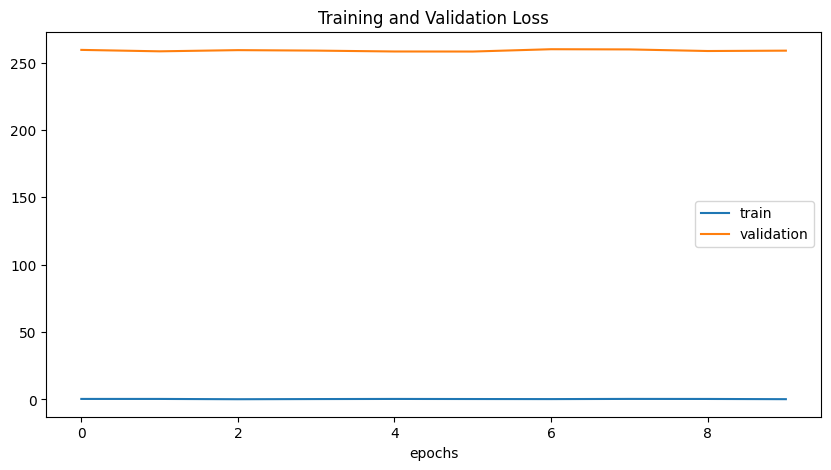

In [11]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(all_loss,label="train")
#plt.plot(all_val,label="validation")
plt.xlabel("epochs")
plt.ylabel
plt.legend()
plt.show()

In [12]:
def random_model(images):
    batch_size = images.shape[0]
    return torch.rand(batch_size, 2).to(device)

In [12]:
n_epoch = 10
all_loss = []
all_val = []

for epoch in range(n_epoch):
    model.train()
    temp_loss = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)  

        output = (random_model(images))  #mettre une sigmoid utile? ou une transfo pour log (voir doc)
        
        print(f"output:{output}, output_shpae:{output.shape}")
        #print(f"label: {labels}, label_shape:{labels.shape}")

        loss = criterion(output, labels)
        #print(f"loss:{loss}, loss_shape:{loss.shape}")
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        #input()
        temp_loss.append(loss.item())

    train_loss = torch.mean(torch.tensor(temp_loss), dim=0).item()
    all_loss.append(train_loss)
    
    
    model.eval()  # Mode d'évaluation
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")
            output = (random_model(images))
            val_loss += criterion(output, labels).item() #criterion(output, torch.argmax(labels, dim=1)).item()
            
            _, labels_ = torch.max(labels, 1) #BCEWithLogitsLoss()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels_).sum().item() #(predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(valloader)
    all_val.append(val_loss)

    print(f"Epoch [{epoch+1}/{n_epoch}], Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")

NameError: name 'model' is not defined

# Random Model

In [8]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=150528, output_dim=2):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)
    torch.nn.init.normal_(self.linear.weight)
    torch.nn.init.zeros_(self.linear.bias)

  def forward(self, x):
    x = self.linear(x)
    return x
  
device = torch.device("mps")
random_model = LinearClassifier().to(device)  # This will now be your randomly initialized model
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(random_model.parameters(), lr=0.00001, weight_decay=0.1)


In [10]:
def val_without_train():
    random_model.eval()  # Mode d'évaluation
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")
            output = (random_model(images))
            val_loss = criterion(output, labels).item() #criterion(output, torch.argmax(labels, dim=1)).item()
                
            _, labels_ = torch.max(labels, 1) #BCEWithLogitsLoss()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels_).sum().item() #(predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = 100 * correct / total
    val_loss /= len(valloader)
    print(f"Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")

def train_loss_without_train():
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")

            output = (random_model(images))
            loss = criterion(output, labels) #criterion(output, torch.argmax(labels, dim=1)).item()
            total_loss += loss # Accumuler la perte pour le mini-lot
            total_samples += images.size(0)  # Accumuler le nombre total d'échantillons
            
            _, labels_ = torch.max(labels, 1)
            _, predicted = torch.max(output.data, 1)
            correct_predictions += (predicted == labels_).sum().item()  # Accumuler le nombre de prédictions correctes

    train_loss = total_loss / total_samples
    train_accuracy = (100 * correct_predictions) / total_samples
    print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy}%")
    
val_without_train()
train_loss_without_train()


Val Loss: 6.113921564275568, Val Accuracy: 33.9568345323741%
Train Loss: 0.006184648256748915, Train Accuracy: 99.95926680244399%


In [9]:
n_epoch = 10
all_train_loss = []
train_acc = []
all_val = []
correct_train = 0
correct_val = 0
total_train = 0
total_val = 0



for epoch in range(n_epoch):
    random_model.train()  
    temp_loss = []
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)  

        #forward pass
        output = random_model(images)
        loss = criterion(output, labels)

        #print(f"output:{output}, output_shpae:{output.shape}")
        #print(f"label: {labels}, label_shape:{labels.shape}")

        #print(f"loss:{loss}, loss_shape:{loss.shape}")
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(random_model.parameters(), max_norm=1) 
        optimizer.step()
        #input()
        temp_loss.append(loss.item())

    train_loss = torch.mean(torch.tensor(temp_loss), dim=0).item()
    all_train_loss.append(train_loss)

    _, labels_train = torch.max(labels, 1)
    _, predicted_train = torch.max(output.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted_train == labels_train).sum().item() 
    train_accuracy = (100 * correct_train) / total_train
    
    
    random_model.eval()  # change here

    val_loss = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            #print(f"output:{output}, output_shpae:{output.shape}")
            #print(f"label: {labels}, label_shape:{labels.shape}")
            output = random_model(images)  # change here
            val_loss = criterion(output, labels).item() #criterion(output, torch.argmax(labels, dim=1)).item()
            
            _, labels_ = torch.max(labels, 1) #BCEWithLogitsLoss()
            _, predicted = torch.max(output.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels_).sum().item() #(predicted == torch.argmax(labels, dim=1)).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss /= len(valloader)
    all_val.append(val_loss)

    print(f"Epoch [{epoch+1}/{n_epoch}], Train Loss: {train_loss}, Train Accuracy: {train_accuracy} Val Loss: {val_loss}, Val Accuracy: {val_accuracy}%")


Epoch [1/10], Train Loss: 0.3609545826911926, Train Accuracy: 100.0 Val Loss: 4.880095481872559, Val Accuracy: 33.9568345323741%
Epoch [2/10], Train Loss: 0.3536545932292938, Train Accuracy: 100.0 Val Loss: 3.364863634109497, Val Accuracy: 33.9568345323741%
Epoch [3/10], Train Loss: 0.14589045941829681, Train Accuracy: 100.0 Val Loss: 4.612350940704346, Val Accuracy: 33.9568345323741%
Epoch [4/10], Train Loss: 0.26411253213882446, Train Accuracy: 100.0 Val Loss: 4.113014221191406, Val Accuracy: 33.96402877697842%
Epoch [5/10], Train Loss: 0.35027796030044556, Train Accuracy: 100.0 Val Loss: 3.18269419670105, Val Accuracy: 33.968345323741005%
Epoch [6/10], Train Loss: 0.28364118933677673, Train Accuracy: 100.0 Val Loss: 3.1176400184631348, Val Accuracy: 33.97122302158273%
Epoch [7/10], Train Loss: 0.23311658203601837, Train Accuracy: 100.0 Val Loss: 5.560276031494141, Val Accuracy: 33.969167523124355%
Epoch [8/10], Train Loss: 0.3576347827911377, Train Accuracy: 100.0 Val Loss: 5.359636

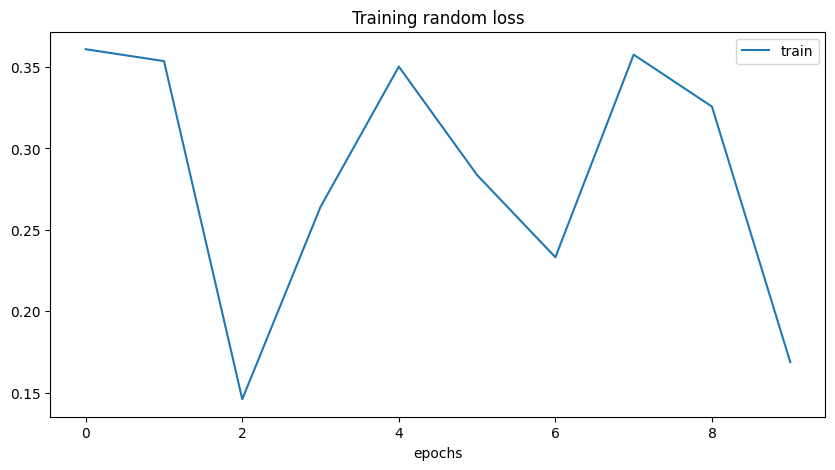

In [10]:
plt.figure(figsize=(10,5))
plt.title("Training random loss")
plt.plot(all_loss,label="train")
#plt.plot(all_val,label="validation")
plt.xlabel("epochs")
plt.ylabel
plt.legend()
plt.show()

considérer un modèle (avec normal), faire prédire 
1. sur entrainement et val la performance (loss et accuracy)
2. faire la figure : evolution de la losstrain sur train et val
3. Une manière de mesurer la loss
4. Générer un vecteur de prédiction de manière aléatoire (output avec même format).
5. figure synthèse pour voir comment l'entrainement se passe; ordre de grandeur de la courbe de loss aléatoire vs réel
6. modèle aléatoire a pas but optimisé
7. performance avant entrainement et après entrainement
8. génerer valeur aléatoire et -100 et 100 mesurer accuracy, génerer deux labels avec les vrais etiquettes
9. loss et accuracy de l'aléatoire, accuracy de l'aléatoire et courbe train linéaire puis établir conclusion